In [1]:
import os, random, time, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# XAI libs
from captum.attr import Saliency, NoiseTunnel, LayerLRP
from torchcam.methods import GradCAM

# Seed & device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True


Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER


In [2]:
# =====  Config for high-accuracy CIFAR-10 =====
DATASET = "CIFAR10"
BATCH_SIZE = 256          # larger batch helps with AMP on GPU
EPOCHS = 200              # strong sched needs longer training
BASE_LR = 0.2             # LR scales with batch; we'll use cosine scheduler
WEIGHT_DECAY = 5e-4
LABEL_SMOOTH = 0.1
MIXUP_ALPHA = 0.2         # set 0.0 to disable
CUTMIX_ALPHA = 1.0        # set 0.0 to disable
NUM_WORKERS = 4
NUM_SAMPLES_EXPLAIN = 5
SMOOTHGRAD_SAMPLES = 25
CHECKPOINT_PATH = 'resnet18_cifar10_best.pth'


In [3]:
# ===== CIFAR-10 with RandAugment + Cutout =====
from torchvision.transforms import RandAugment

assert DATASET.upper() == "CIFAR10", "This recipe targets CIFAR-10."
num_classes = 10
in_ch = 3
mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),       # strong, but stable
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=NUM_WORKERS>0)
testloader  = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=NUM_WORKERS>0)

classes = trainset.classes
len(trainset), len(testset), classes[:5]


(50000, 10000, ['airplane', 'automobile', 'bird', 'cat', 'deer'])

In [4]:
# =====  ResNet-18 adapted for CIFAR-10 (3x3 stem, stride 1) =====
from torchvision.models.resnet import ResNet, BasicBlock

class ResNet18_CIFAR(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(block=BasicBlock, layers=[2,2,2,2], num_classes=num_classes)
        # Replace ImageNet stem (7x7, stride 2) with CIFAR stem (3x3, stride 1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.maxpool = nn.Identity()  # no downsample at start

model = ResNet18_CIFAR(num_classes=num_classes).to(device)

# quick sanity
x_chk = next(iter(testloader))[0][:2].to(device)
with torch.no_grad(): y_chk = model(x_chk)
y_chk.shape


torch.Size([2, 10])

In [5]:
# 5. Mixed precision training (GPU)

In [6]:
# =====  Loss/opt/sched + AMP + MixUp/CutMix =====
from torch.amp import autocast, GradScaler
scaler = GradScaler(device="cuda")

# Label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(device)

# SGD with momentum (standard for CIFAR SOTA-ish)
optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=0.9, weight_decay=WEIGHT_DECAY, nesterov=True)

# Cosine Annealing LR with warmup
warmup_epochs = 5
total_steps = EPOCHS * len(trainloader)
warmup_steps = warmup_epochs * len(trainloader)
cosine_steps = total_steps - warmup_steps

def cosine_warmup(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    t = (step - warmup_steps) / max(1, cosine_steps)
    return 0.5 * (1 + np.cos(np.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=cosine_warmup)

# MixUp / CutMix helpers
def rand_beta(alpha):
    return np.random.beta(alpha, alpha) if alpha > 0. else 1.0

def mixup_cutmix_data(x, y, mixup_alpha=MIXUP_ALPHA, cutmix_alpha=CUTMIX_ALPHA):
    lam = 1.0
    use_cutmix = (cutmix_alpha > 1e-8) and (np.random.rand() < 0.5)
    if use_cutmix:
        lam = rand_beta(cutmix_alpha)
        B, C, H, W = x.size()
        cx, cy = np.random.randint(W), np.random.randint(H)
        w = int(W * np.sqrt(1 - lam))
        h = int(H * np.sqrt(1 - lam))
        x1 = np.clip(cx - w // 2, 0, W)
        x2 = np.clip(cx + w // 2, 0, W)
        y1 = np.clip(cy - h // 2, 0, H)
        y2 = np.clip(cy + h // 2, 0, H)
        idx = torch.randperm(B, device=x.device)
        x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
        y_a, y_b = y, y[idx]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        return x, y_a, y_b, lam
    elif mixup_alpha > 1e-8:
        lam = rand_beta(mixup_alpha)
        idx = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[idx, :]
        y_a, y_b = y, y[idx]
        return mixed_x, y_a, y_b, lam
    else:
        return x, y, None, None  # no mix

def mix_criterion(criterion, pred, y_a, y_b=None, lam=None):
    if y_b is None or lam is None:
        return criterion(pred, y_a)
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [7]:
# ===== Train/Eval with AMP + Cosine + MixUp/CutMix + EMA =====
import copy
import torch

class ModelEMA:
    def __init__(self, model, decay=0.9997):
        # exact copy of the current model (incl. buffers) but frozen
        self.ema = copy.deepcopy(model).to(device)
        self.ema.eval()
        for p in self.ema.parameters():
            p.requires_grad_(False)
        self.decay = decay

    @torch.no_grad()
    def update(self, model):
        msd = model.state_dict()
        esd = self.ema.state_dict()
        d = self.decay
        for k, v in esd.items():
            mv = msd[k]
            if torch.is_floating_point(v):
                # EMA on floating tensors
                v.mul_(d).add_(mv.to(v.dtype), alpha=1.0 - d)
            else:
                # copy ints / bools / longs directly (e.g., num_batches_tracked)
                v.copy_(mv)

ema = ModelEMA(model, decay=0.9997)

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0
    global_step = 0
    for x, y in tqdm(loader, desc='Train'):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # MixUp/CutMix on GPU
        x, y_a, y_b, lam = mixup_cutmix_data(x, y)

        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda"):
            logits = model(x)
            loss = mix_criterion(criterion, logits, y_a, y_b, lam)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        ema.update(model)

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        # accuracy computed on mixed targets is not meaningful → use unmixed batch for quick proxy
        correct += pred.eq(y_a).sum().item()
        total   += y.size(0)

        scheduler.step()
    return loss_sum/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc='Eval'):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with autocast("cuda"):
            logits = model(x)
            loss = criterion(logits, y)  # plain CE for eval
        loss_sum += loss.item() * x.size(0)
        correct  += logits.argmax(1).eq(y).sum().item()
        total    += y.size(0)
    return loss_sum/total, correct/total

best = 0.0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, trainloader, optimizer, scheduler)
    va_loss, va_acc = evaluate(ema.ema, testloader)  # evaluate EMA weights
    if va_acc > best:
        best = va_acc
        torch.save(ema.ema.state_dict(), CHECKPOINT_PATH)
    print(f"Epoch {ep:03d} | train_acc≈{tr_acc:.3f} | val_acc={va_acc:.3f} | best={best:.3f}")
print("Best validation accuracy:", best)


Eval: 100%|██████████| 40/40 [00:00<00:00, 90.38it/s]


Epoch 001 | train_acc≈0.207 | val_acc=0.080 | best=0.080


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.22it/s]


Epoch 002 | train_acc≈0.289 | val_acc=0.079 | best=0.080


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.52it/s]


Epoch 003 | train_acc≈0.367 | val_acc=0.114 | best=0.114


Eval: 100%|██████████| 40/40 [00:00<00:00, 102.54it/s]


Epoch 004 | train_acc≈0.407 | val_acc=0.145 | best=0.145


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.42it/s]


Epoch 005 | train_acc≈0.440 | val_acc=0.172 | best=0.172


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.22it/s]


Epoch 006 | train_acc≈0.459 | val_acc=0.193 | best=0.193


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.81it/s]


Epoch 007 | train_acc≈0.462 | val_acc=0.200 | best=0.200


Eval: 100%|██████████| 40/40 [00:00<00:00, 102.07it/s]


Epoch 008 | train_acc≈0.487 | val_acc=0.214 | best=0.214


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.31it/s]


Epoch 009 | train_acc≈0.515 | val_acc=0.235 | best=0.235


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.68it/s]


Epoch 010 | train_acc≈0.442 | val_acc=0.252 | best=0.252


Eval: 100%|██████████| 40/40 [00:00<00:00, 101.25it/s]


Epoch 011 | train_acc≈0.519 | val_acc=0.265 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.93it/s]


Epoch 012 | train_acc≈0.500 | val_acc=0.253 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.13it/s]


Epoch 013 | train_acc≈0.470 | val_acc=0.239 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.67it/s]


Epoch 014 | train_acc≈0.506 | val_acc=0.221 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.92it/s]


Epoch 015 | train_acc≈0.512 | val_acc=0.203 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.10it/s]


Epoch 016 | train_acc≈0.522 | val_acc=0.191 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.53it/s]


Epoch 017 | train_acc≈0.475 | val_acc=0.180 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.41it/s]


Epoch 018 | train_acc≈0.480 | val_acc=0.177 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.23it/s]


Epoch 019 | train_acc≈0.487 | val_acc=0.174 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.59it/s]


Epoch 020 | train_acc≈0.502 | val_acc=0.170 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.44it/s]


Epoch 021 | train_acc≈0.542 | val_acc=0.168 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.14it/s]


Epoch 022 | train_acc≈0.531 | val_acc=0.167 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.90it/s]


Epoch 023 | train_acc≈0.541 | val_acc=0.167 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.05it/s]


Epoch 024 | train_acc≈0.516 | val_acc=0.166 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.65it/s]


Epoch 025 | train_acc≈0.537 | val_acc=0.168 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 94.22it/s]


Epoch 026 | train_acc≈0.545 | val_acc=0.169 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.76it/s]


Epoch 027 | train_acc≈0.493 | val_acc=0.161 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.07it/s]


Epoch 028 | train_acc≈0.518 | val_acc=0.149 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.27it/s]


Epoch 029 | train_acc≈0.508 | val_acc=0.131 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.66it/s]


Epoch 030 | train_acc≈0.508 | val_acc=0.109 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.38it/s]


Epoch 031 | train_acc≈0.523 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.00it/s]


Epoch 032 | train_acc≈0.527 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.39it/s]


Epoch 033 | train_acc≈0.515 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.18it/s]


Epoch 034 | train_acc≈0.540 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.21it/s]


Epoch 035 | train_acc≈0.481 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.64it/s]


Epoch 036 | train_acc≈0.540 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.64it/s]


Epoch 037 | train_acc≈0.533 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.14it/s]


Epoch 038 | train_acc≈0.470 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 94.69it/s]


Epoch 039 | train_acc≈0.541 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.13it/s]


Epoch 040 | train_acc≈0.526 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 88.08it/s]


Epoch 041 | train_acc≈0.562 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 92.97it/s]


Epoch 042 | train_acc≈0.543 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.09it/s]


Epoch 043 | train_acc≈0.541 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.46it/s]


Epoch 044 | train_acc≈0.516 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.01it/s]


Epoch 045 | train_acc≈0.553 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.31it/s]


Epoch 046 | train_acc≈0.536 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.96it/s]


Epoch 047 | train_acc≈0.548 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.61it/s]


Epoch 048 | train_acc≈0.513 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.93it/s]


Epoch 049 | train_acc≈0.500 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.20it/s]


Epoch 050 | train_acc≈0.538 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.41it/s]


Epoch 051 | train_acc≈0.501 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.96it/s]


Epoch 052 | train_acc≈0.565 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.52it/s]


Epoch 053 | train_acc≈0.557 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.56it/s]


Epoch 054 | train_acc≈0.558 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.76it/s]


Epoch 055 | train_acc≈0.562 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.61it/s]


Epoch 056 | train_acc≈0.558 | val_acc=0.100 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.75it/s]


Epoch 057 | train_acc≈0.526 | val_acc=0.101 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.53it/s]


Epoch 058 | train_acc≈0.544 | val_acc=0.103 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.77it/s]


Epoch 059 | train_acc≈0.545 | val_acc=0.108 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.48it/s]


Epoch 060 | train_acc≈0.559 | val_acc=0.112 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.65it/s]


Epoch 061 | train_acc≈0.515 | val_acc=0.117 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.94it/s]


Epoch 062 | train_acc≈0.500 | val_acc=0.124 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.24it/s]


Epoch 063 | train_acc≈0.527 | val_acc=0.133 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.57it/s]


Epoch 064 | train_acc≈0.560 | val_acc=0.144 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.02it/s]


Epoch 065 | train_acc≈0.548 | val_acc=0.159 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.09it/s]


Epoch 066 | train_acc≈0.531 | val_acc=0.180 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.01it/s]


Epoch 067 | train_acc≈0.543 | val_acc=0.204 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.00it/s]


Epoch 068 | train_acc≈0.546 | val_acc=0.231 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.45it/s]


Epoch 069 | train_acc≈0.571 | val_acc=0.250 | best=0.265


Eval: 100%|██████████| 40/40 [00:00<00:00, 93.92it/s]


Epoch 070 | train_acc≈0.520 | val_acc=0.270 | best=0.270


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.13it/s]


Epoch 071 | train_acc≈0.570 | val_acc=0.292 | best=0.292


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.96it/s]


Epoch 072 | train_acc≈0.522 | val_acc=0.321 | best=0.321


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.68it/s]


Epoch 073 | train_acc≈0.528 | val_acc=0.354 | best=0.354


Eval: 100%|██████████| 40/40 [00:00<00:00, 93.99it/s]


Epoch 074 | train_acc≈0.551 | val_acc=0.387 | best=0.387


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.01it/s]


Epoch 075 | train_acc≈0.532 | val_acc=0.419 | best=0.419


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.59it/s]


Epoch 076 | train_acc≈0.505 | val_acc=0.456 | best=0.456


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.82it/s]


Epoch 077 | train_acc≈0.518 | val_acc=0.485 | best=0.485


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.30it/s]


Epoch 078 | train_acc≈0.515 | val_acc=0.515 | best=0.515


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.17it/s]


Epoch 079 | train_acc≈0.517 | val_acc=0.544 | best=0.544


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.24it/s]


Epoch 080 | train_acc≈0.547 | val_acc=0.574 | best=0.574


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.94it/s]


Epoch 081 | train_acc≈0.552 | val_acc=0.600 | best=0.600


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.29it/s]


Epoch 082 | train_acc≈0.581 | val_acc=0.621 | best=0.621


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.59it/s]


Epoch 083 | train_acc≈0.543 | val_acc=0.644 | best=0.644


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.52it/s]


Epoch 084 | train_acc≈0.555 | val_acc=0.666 | best=0.666


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.59it/s]


Epoch 085 | train_acc≈0.519 | val_acc=0.687 | best=0.687


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.71it/s]


Epoch 086 | train_acc≈0.575 | val_acc=0.705 | best=0.705


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.10it/s]


Epoch 087 | train_acc≈0.572 | val_acc=0.724 | best=0.724


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.66it/s]


Epoch 088 | train_acc≈0.571 | val_acc=0.741 | best=0.741


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.77it/s]


Epoch 089 | train_acc≈0.571 | val_acc=0.758 | best=0.758


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.71it/s]


Epoch 090 | train_acc≈0.513 | val_acc=0.773 | best=0.773


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.54it/s]


Epoch 091 | train_acc≈0.589 | val_acc=0.789 | best=0.789


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.23it/s]


Epoch 092 | train_acc≈0.537 | val_acc=0.801 | best=0.801


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.55it/s]


Epoch 093 | train_acc≈0.538 | val_acc=0.813 | best=0.813


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.33it/s]


Epoch 094 | train_acc≈0.532 | val_acc=0.824 | best=0.824


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.21it/s]


Epoch 095 | train_acc≈0.546 | val_acc=0.835 | best=0.835


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.11it/s]


Epoch 096 | train_acc≈0.532 | val_acc=0.846 | best=0.846


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.91it/s]


Epoch 097 | train_acc≈0.573 | val_acc=0.854 | best=0.854


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.51it/s]


Epoch 098 | train_acc≈0.554 | val_acc=0.863 | best=0.863


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.76it/s]


Epoch 099 | train_acc≈0.522 | val_acc=0.870 | best=0.870


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.45it/s]


Epoch 100 | train_acc≈0.580 | val_acc=0.876 | best=0.876


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.01it/s]


Epoch 101 | train_acc≈0.537 | val_acc=0.882 | best=0.882


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.82it/s]


Epoch 102 | train_acc≈0.583 | val_acc=0.887 | best=0.887


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.92it/s]


Epoch 103 | train_acc≈0.548 | val_acc=0.892 | best=0.892


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.55it/s]


Epoch 104 | train_acc≈0.544 | val_acc=0.897 | best=0.897


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.92it/s]


Epoch 105 | train_acc≈0.570 | val_acc=0.902 | best=0.902


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.32it/s]


Epoch 106 | train_acc≈0.548 | val_acc=0.905 | best=0.905


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.67it/s]


Epoch 107 | train_acc≈0.614 | val_acc=0.907 | best=0.907


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.66it/s]


Epoch 108 | train_acc≈0.510 | val_acc=0.909 | best=0.909


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.79it/s]


Epoch 109 | train_acc≈0.616 | val_acc=0.912 | best=0.912


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.54it/s]


Epoch 110 | train_acc≈0.518 | val_acc=0.915 | best=0.915


Eval: 100%|██████████| 40/40 [00:00<00:00, 94.06it/s]


Epoch 111 | train_acc≈0.554 | val_acc=0.916 | best=0.916


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.86it/s]


Epoch 112 | train_acc≈0.549 | val_acc=0.918 | best=0.918


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.30it/s]


Epoch 113 | train_acc≈0.520 | val_acc=0.920 | best=0.920


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.55it/s]


Epoch 114 | train_acc≈0.598 | val_acc=0.922 | best=0.922


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.83it/s]


Epoch 115 | train_acc≈0.573 | val_acc=0.924 | best=0.924


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.13it/s]


Epoch 116 | train_acc≈0.605 | val_acc=0.926 | best=0.926


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.40it/s] 


Epoch 117 | train_acc≈0.534 | val_acc=0.927 | best=0.927


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.08it/s]


Epoch 118 | train_acc≈0.535 | val_acc=0.928 | best=0.928


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.81it/s]


Epoch 119 | train_acc≈0.577 | val_acc=0.930 | best=0.930


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.14it/s]


Epoch 120 | train_acc≈0.567 | val_acc=0.930 | best=0.930


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.11it/s]


Epoch 121 | train_acc≈0.578 | val_acc=0.932 | best=0.932


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.62it/s]


Epoch 122 | train_acc≈0.531 | val_acc=0.934 | best=0.934


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.15it/s]


Epoch 123 | train_acc≈0.581 | val_acc=0.934 | best=0.934


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.80it/s]


Epoch 124 | train_acc≈0.536 | val_acc=0.936 | best=0.936


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.00it/s]


Epoch 125 | train_acc≈0.568 | val_acc=0.936 | best=0.936


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.17it/s]


Epoch 126 | train_acc≈0.594 | val_acc=0.937 | best=0.937


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.04it/s]


Epoch 127 | train_acc≈0.570 | val_acc=0.938 | best=0.938


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.16it/s]


Epoch 128 | train_acc≈0.555 | val_acc=0.938 | best=0.938


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.98it/s]


Epoch 129 | train_acc≈0.549 | val_acc=0.940 | best=0.940


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.37it/s]


Epoch 130 | train_acc≈0.581 | val_acc=0.941 | best=0.941


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.09it/s]


Epoch 131 | train_acc≈0.608 | val_acc=0.942 | best=0.942


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.55it/s]


Epoch 132 | train_acc≈0.573 | val_acc=0.943 | best=0.943


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.41it/s]


Epoch 133 | train_acc≈0.578 | val_acc=0.944 | best=0.944


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.77it/s]


Epoch 134 | train_acc≈0.564 | val_acc=0.945 | best=0.945


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.82it/s]


Epoch 135 | train_acc≈0.546 | val_acc=0.946 | best=0.946


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.61it/s]


Epoch 136 | train_acc≈0.577 | val_acc=0.946 | best=0.946


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.57it/s]


Epoch 137 | train_acc≈0.633 | val_acc=0.946 | best=0.946


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.14it/s]


Epoch 138 | train_acc≈0.596 | val_acc=0.947 | best=0.947


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.21it/s]


Epoch 139 | train_acc≈0.606 | val_acc=0.947 | best=0.947


Eval: 100%|██████████| 40/40 [00:00<00:00, 94.90it/s]


Epoch 140 | train_acc≈0.597 | val_acc=0.948 | best=0.948


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.38it/s]


Epoch 141 | train_acc≈0.604 | val_acc=0.948 | best=0.948


Eval: 100%|██████████| 40/40 [00:00<00:00, 94.70it/s]


Epoch 142 | train_acc≈0.610 | val_acc=0.949 | best=0.949


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.42it/s]


Epoch 143 | train_acc≈0.573 | val_acc=0.950 | best=0.950


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.60it/s]


Epoch 144 | train_acc≈0.581 | val_acc=0.950 | best=0.950


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.17it/s]


Epoch 145 | train_acc≈0.619 | val_acc=0.950 | best=0.950


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.47it/s]


Epoch 146 | train_acc≈0.583 | val_acc=0.950 | best=0.950


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.82it/s]


Epoch 147 | train_acc≈0.605 | val_acc=0.951 | best=0.951


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.79it/s]


Epoch 148 | train_acc≈0.668 | val_acc=0.951 | best=0.951


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.39it/s]


Epoch 149 | train_acc≈0.604 | val_acc=0.952 | best=0.952


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.83it/s]


Epoch 150 | train_acc≈0.638 | val_acc=0.952 | best=0.952


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.48it/s]


Epoch 151 | train_acc≈0.578 | val_acc=0.952 | best=0.952


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.30it/s]


Epoch 152 | train_acc≈0.607 | val_acc=0.952 | best=0.952


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.29it/s]


Epoch 153 | train_acc≈0.606 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.21it/s]


Epoch 154 | train_acc≈0.653 | val_acc=0.952 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.54it/s]


Epoch 155 | train_acc≈0.581 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.31it/s]


Epoch 156 | train_acc≈0.589 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.14it/s]


Epoch 157 | train_acc≈0.597 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.03it/s]


Epoch 158 | train_acc≈0.640 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.31it/s]


Epoch 159 | train_acc≈0.614 | val_acc=0.953 | best=0.953


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.88it/s]


Epoch 160 | train_acc≈0.626 | val_acc=0.954 | best=0.954


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.35it/s]


Epoch 161 | train_acc≈0.623 | val_acc=0.954 | best=0.954


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.97it/s]


Epoch 162 | train_acc≈0.620 | val_acc=0.954 | best=0.954


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.50it/s]


Epoch 163 | train_acc≈0.605 | val_acc=0.955 | best=0.955


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.53it/s]


Epoch 164 | train_acc≈0.633 | val_acc=0.955 | best=0.955


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.99it/s]


Epoch 165 | train_acc≈0.632 | val_acc=0.955 | best=0.955


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.75it/s]


Epoch 166 | train_acc≈0.596 | val_acc=0.956 | best=0.956


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.31it/s]


Epoch 167 | train_acc≈0.616 | val_acc=0.956 | best=0.956


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.09it/s]


Epoch 168 | train_acc≈0.633 | val_acc=0.956 | best=0.956


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.42it/s]


Epoch 169 | train_acc≈0.613 | val_acc=0.957 | best=0.957


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.98it/s]


Epoch 170 | train_acc≈0.637 | val_acc=0.957 | best=0.957


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.67it/s]


Epoch 171 | train_acc≈0.655 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.49it/s]


Epoch 172 | train_acc≈0.615 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.03it/s]


Epoch 173 | train_acc≈0.619 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.25it/s]


Epoch 174 | train_acc≈0.641 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.33it/s]


Epoch 175 | train_acc≈0.620 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.35it/s]


Epoch 176 | train_acc≈0.620 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.47it/s]


Epoch 177 | train_acc≈0.649 | val_acc=0.958 | best=0.958


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.61it/s]


Epoch 178 | train_acc≈0.673 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.70it/s]


Epoch 179 | train_acc≈0.669 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.86it/s]


Epoch 180 | train_acc≈0.659 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.71it/s]


Epoch 181 | train_acc≈0.651 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.15it/s]


Epoch 182 | train_acc≈0.688 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.16it/s]


Epoch 183 | train_acc≈0.675 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.03it/s]


Epoch 184 | train_acc≈0.648 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.51it/s]


Epoch 185 | train_acc≈0.639 | val_acc=0.959 | best=0.959


Eval: 100%|██████████| 40/40 [00:00<00:00, 96.94it/s]


Epoch 186 | train_acc≈0.668 | val_acc=0.960 | best=0.960


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.51it/s]


Epoch 187 | train_acc≈0.679 | val_acc=0.961 | best=0.961


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.28it/s]


Epoch 188 | train_acc≈0.658 | val_acc=0.961 | best=0.961


Eval: 100%|██████████| 40/40 [00:00<00:00, 97.01it/s]


Epoch 189 | train_acc≈0.650 | val_acc=0.962 | best=0.962


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.71it/s]


Epoch 190 | train_acc≈0.665 | val_acc=0.962 | best=0.962


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.20it/s]


Epoch 191 | train_acc≈0.641 | val_acc=0.963 | best=0.963


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.46it/s]


Epoch 192 | train_acc≈0.666 | val_acc=0.963 | best=0.963


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.21it/s]


Epoch 193 | train_acc≈0.629 | val_acc=0.963 | best=0.963


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.11it/s]


Epoch 194 | train_acc≈0.671 | val_acc=0.963 | best=0.963


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.15it/s]


Epoch 195 | train_acc≈0.670 | val_acc=0.964 | best=0.964


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.99it/s]


Epoch 196 | train_acc≈0.651 | val_acc=0.964 | best=0.964


Eval: 100%|██████████| 40/40 [00:00<00:00, 100.25it/s]


Epoch 197 | train_acc≈0.656 | val_acc=0.964 | best=0.964


Eval: 100%|██████████| 40/40 [00:00<00:00, 98.44it/s]


Epoch 198 | train_acc≈0.626 | val_acc=0.964 | best=0.964


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.48it/s]


Epoch 199 | train_acc≈0.673 | val_acc=0.964 | best=0.964


Eval: 100%|██████████| 40/40 [00:00<00:00, 99.33it/s]

Epoch 200 | train_acc≈0.638 | val_acc=0.964 | best=0.964
Best validation accuracy: 0.9642


In [8]:
def denormalize(img: torch.Tensor, mean, std):
    mean_t = torch.tensor(mean, device=img.device).view(-1,1,1)
    std_t  = torch.tensor(std,  device=img.device).view(-1,1,1)
    return img * std_t + mean_t

def to_numpy_img(t: torch.Tensor):
    x = t.detach().clamp(0,1)
    if x.device.type != "cpu":
        x = x.cpu()
    if x.shape[0] == 1:
        x = x.expand(3, -1, -1)
    return x.permute(1,2,0).numpy()

def overlay_heatmap_on_image(img_np, heatmap_np, alpha=0.5):
    H, W = img_np.shape[:2]
    if heatmap_np.ndim == 3:
        heatmap_np = heatmap_np.squeeze()
    heatmap = cv2.resize(heatmap_np, (W, H), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap_color = cv2.applyColorMap((heatmap*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)/255.0
    return np.clip((1-alpha)*img_np + alpha*heatmap_color, 0, 1)

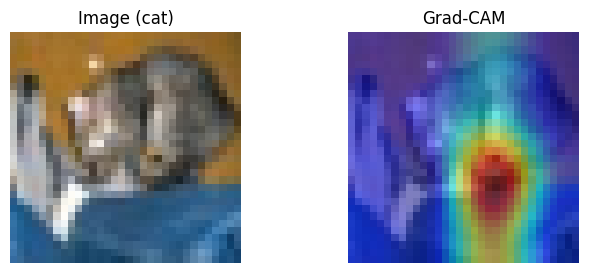

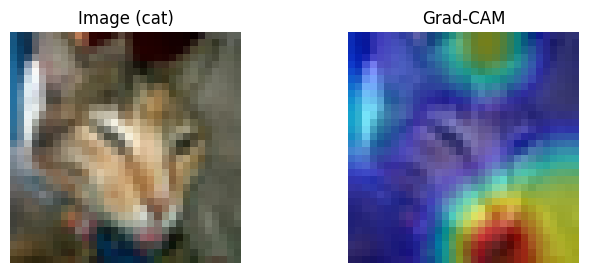

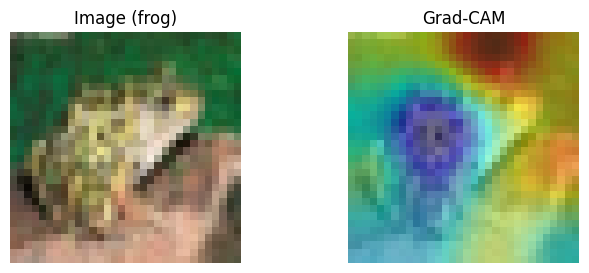

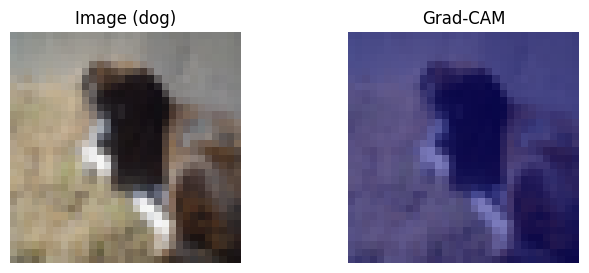

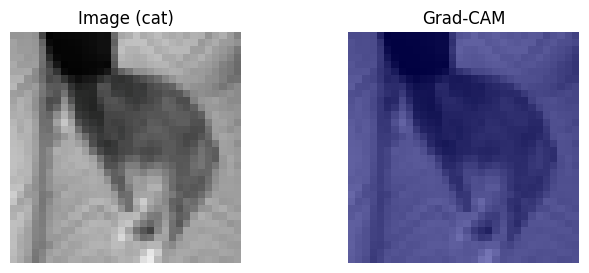

In [12]:
# ===== Grad-CAM for ResNet-18 =====
import torch.nn as nn
from torchcam.methods import GradCAM

model.eval()

# pick the last Conv2d in the network (safe & generic)
last_conv = [m for m in model.modules() if isinstance(m, nn.Conv2d)][-1]
cam_extractor = GradCAM(model, target_layer=last_conv)

gradcam_results = []
with torch.enable_grad():
    for x, y in testloader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1)
        mask = preds.eq(y)
        if mask.any():
            b = mask.nonzero(as_tuple=True)[0][0].item()
            xb = x[b:b+1].clone().requires_grad_(True)
            model.zero_grad(set_to_none=True)
            scores = model(xb)
            pred = int(scores.argmax(1).item())
            cams = cam_extractor(pred, scores)  # list (one per target layer)
            cam = cams[0].squeeze().detach().cpu().numpy()
            img_np = to_numpy_img(denormalize(xb[0], mean, std))
            overlay = overlay_heatmap_on_image(img_np, cam)
            gradcam_results.append((img_np, overlay, classes[pred]))
        if len(gradcam_results) >= NUM_SAMPLES_EXPLAIN:
            break

for img, ov, lbl in gradcam_results:
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.title(f"Image ({lbl})"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(ov);  plt.title("Grad-CAM");        plt.axis('off')
    plt.show()


DeepLiftShap fallback -> IntegratedGradients due to: A Module ReLU() was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.


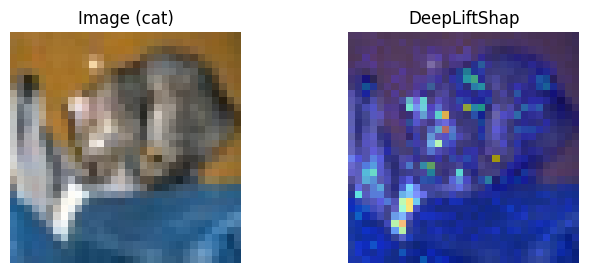

In [18]:
# ==== Fix in-place ReLUs and run DeepLiftShap on ResNet-18 ====
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import DeepLiftShap, IntegratedGradients

model.eval()

# 0) Remove any leftover CAM hooks
try:
    cam_extractor.remove_hooks()
except Exception:
    pass

# 1) Patch all in-place ReLUs -> out-of-place (required by DeepLIFT family)
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

# 2) Prepare input (gradients ON)
xb = next(iter(testloader))[0][0:1].to(device).requires_grad_(True)

with torch.enable_grad():
    scores = model(xb)
t = int(scores.argmax(1).item())

# 3) Run DeepLiftShap (robust) with a simple baseline batch
#    Use 4 zero baselines; you can increase for smoother maps
baselines = torch.zeros((4, *xb.shape[1:]), device=device)
try:
    dls = DeepLiftShap(model)
    attr = dls.attribute(xb, baselines=baselines, target=t)  # (1,C,H,W)
except Exception as e:
    print("DeepLiftShap fallback -> IntegratedGradients due to:", e)
    ig = IntegratedGradients(model)
    attr = ig.attribute(xb, target=t, n_steps=32)

# 4) To heatmap
heat = attr.abs().sum(dim=1).squeeze()
heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
heat = heat.detach().cpu().numpy()

# 5) Visualize (uses your helpers)
img_np = to_numpy_img(denormalize(xb[0], mean, std))
ov = overlay_heatmap_on_image(img_np, heat)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(img_np); plt.title(f"Image ({classes[t]})"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ov);     plt.title("DeepLiftShap");       plt.axis('off')
plt.show()


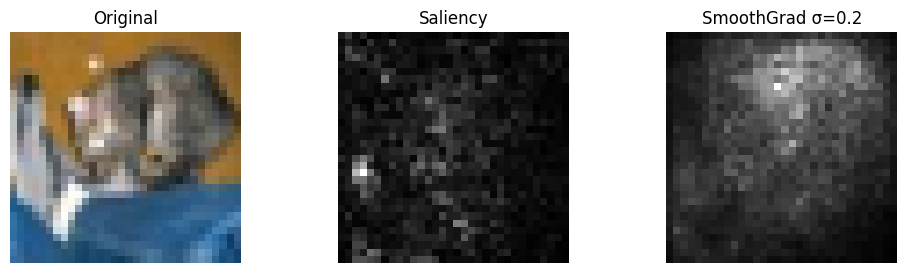

In [19]:
# =====  SmoothGrad =====
model.eval()
sal = Saliency(model)
nt  = NoiseTunnel(sal)

xb = xb.detach().requires_grad_(True)
scores = model(xb)
t = int(scores.argmax(1).item())

base = sal.attribute(xb, target=t).abs().sum(1).squeeze()
base = (base - base.min()) / (base.max() - base.min() + 1e-8)
base = base.detach().cpu().numpy()

sg = nt.attribute(xb, nt_type='smoothgrad', nt_samples=SMOOTHGRAD_SAMPLES, stdevs=0.2, target=t)
sg = sg.abs().sum(1).squeeze()
sg = (sg - sg.min()) / (sg.max() - sg.min() + 1e-8)
sg = sg.detach().cpu().numpy()

img_np = to_numpy_img(denormalize(xb[0], mean, std))
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original");           plt.axis('off')
plt.subplot(1,3,2); plt.imshow(base, cmap='gray'); plt.title("Saliency"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(sg,   cmap='gray'); plt.title("SmoothGrad σ=0.2"); plt.axis('off')
plt.show()
